In [1]:
# 주로 사용하는 코드 2 : 인식한 GPU 개수 출력
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# 카드사용 실시간으로 검토해 평상시 고객의 거래/ 사용내역과 현저히 다를 경우 
# 이상거래로 인식하고 탐지해 카드 사용을 중단하도록 한다.
# 본 데이터 부정거래 케이스 전체 데이터 중 0.17%로 매우 적다
# 불균형 데이터> 정확도 대신해 Precision(정밀도), Recall(재현율), F-1 score 사용
# 불균형 데이터에서도 정확도를 성능 평가 지표로 사용시 모델이 모든 testset을 부정거래가
# 아니라고 예측해도 대부분의 케이스가 부정거래가 아니어서 정확도가 99%가 넘어감
# 적은 케이스로 인해 신뢰도가 떨어진다
# 문제해결을 위해 샘플링 방법 두가지가 있다.
# undersampling: 많은 케이스를 적은 케이스의 빈도에 맞춰 샘플링
# 많은 케이스를 버려야 해서 정보의 손실량이 매우 크다
# oversampling: 적은 케이스를 많은 케이스에 맞춰서 복제
# 적은 케이스를 복제과정을 거쳐 빈도수 맞추기 때문에 과적합 되기 쉽다

In [5]:
pip install imbalanced-learn


ERROR! Session/line number was not unique in database. History logging moved to new session 234
     -------------------------------------- 257.7/257.7 kB 8.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

   ---------------------------------------- 294.9/294.9 kB 9.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Imported Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

#Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections



In [5]:
pip install -U imbalanced-learn

   --------------------------------------- 257.7/257.7 kB 15.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
#Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings

warnings.filterwarnings("ignore")



In [20]:
df = pd.read_csv('./data/creditcard.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
#결측치 확인

df.isnull().sum().max()


0

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

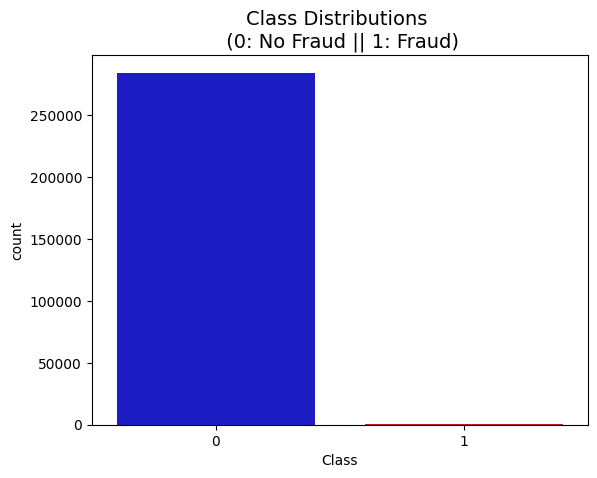

In [11]:
# Class 변수의 범주 비중 보기

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100, 2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100, 2), '% of the dataset')
# Class 변수 시각화

colors = ['#0101DF', '#DF0101']

sns.countplot(x='Class', data = df, palette = colors)
# 범주형 변수의 빈도수를 시각화하는데 사용 class 열을 x축으로 설
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize = 14)

(0.0, 172792.0)

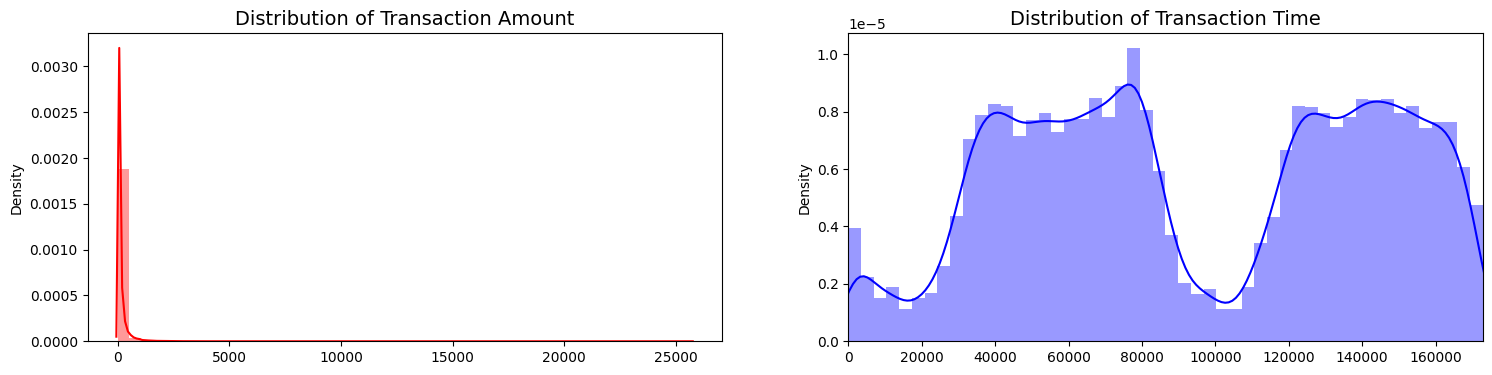

In [15]:
# Amount, time 변수의 분포 시각화
fig,ax=plt.subplots(1,2,figsize=(18,4))

amount_val=df['Amount'].values
time_val=df['Time'].values

sns.distplot(amount_val,ax=ax[0],color='r')
ax[0].set_title('Distribution of Transaction Amount',fontsize=14)
# 연속형 변수 분포 확인시 사용

sns.distplot(time_val,ax=ax[1],color='b')
ax[1].set_title('Distribution of Transaction Time',fontsize=14)
ax[1].set_xlim([min(time_val),max(time_val)])

In [21]:
# 전처리

from sklearn.preprocessing import StandardScaler, RobustScaler

#RobustScaler는 이상치에 둔감하다.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

df.drop(['Time', 'Amount'], axis = 1, inplace = True)


In [22]:
# 스케일링 한 amount, time 변수를 0, 1 로 지정해 df에 삽입
scaled_amount=df['scaled_amount']
scaled_time=df['scaled_time']

df.drop(['scaled_amount','scaled_time'],axis=1,inplace=True)
# axis=1 은 열 중에서 앞에 amount, time을 제거하라는 뜻이다. inplace=true는 원본을 수정하고 즉시 반영하라는 뜻이
df.insert(0,'scaled_amount',scaled_amount)
df.insert(1,'scaled_time',scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [26]:
# 데이터 분할

from sklearn.model_selection import StratifiedShuffleSplit

X=df.drop('Class',axis=1)
y=df['Class']

sss=StratifiedKFold(n_splits=5, random_state=None,shuffle=False)

for train_index,test_index in sss.split(X,y):
    print("Train:",train_index,"Test:",test_index)
    original_XTrain,original_XTest=X.iloc[train_index],X.iloc[test_index]
    original_ytrain,original_ytest=y.iloc[train_index],y.iloc[test_index]

    
#라벨마다 분포 확인하기
original_XTrain = original_XTrain.values
original_XTest = original_XTest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

#trian, test 라벨 분포

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts = True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts = True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]
